# Step_3b_Data_level_approach_Undersampling

**In this notebook we will apply simple classification models after oversampling the minority class**

As we conclude in the notebook :metrics, we will use the roc-auc metric to evaluate the performance of the models and we will analyze the false negative ratio which is what we are interested in minimizing.

# CONTENT

    1. Import Libraries
    2. Load data
    3. Undersampling methods
    4. Modeling
        4.1 Logistic Regression
        4.2 k-Nearest Neighbors
        4.3 Decision Trees
        4.4 Support Vector Machine
        4.5 Random Forest
    5. Summary and conclusions

# 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np


#show cells with width as long as screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.max_columns = None


#Undersampling methods
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, TomekLinks,\
OneSidedSelection, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, \
NeighbourhoodCleaningRule, NearMiss, InstanceHardnessThreshold

#Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)

#metric
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# 2. Load data

This data has been generated in the notebook: step_2_Preprocessing_data

In [5]:
X_train = pd.read_excel('X_train_step_2.xlsx', engine='openpyxl')
X_test =  pd.read_excel('X_test_step_2.xlsx', engine='openpyxl')
y_train = pd.read_excel('y_train_step_2.xlsx', engine='openpyxl')
y_test = pd.read_excel('y_test_step_2.xlsx', engine='openpyxl')

In [6]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0.055556,-0.333333,-0.333333,-0.304304,1.100488,0,0.800,1.572254,2.280255,0.149140,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.444444,-0.333333,-0.333333,3.433433,0.872195,2,2.592,0.254335,-0.394904,-0.187380,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.444444,-0.333333,-0.333333,3.527528,0.872195,2,2.880,0.531792,-0.318471,-0.447419,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,0.611111,-0.333333,-0.333333,0.246246,-0.103415,1,-0.320,-1.040462,-0.802548,0.488209,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0.333333,0.166667,-0.333333,0.568569,-0.103415,1,0.448,1.618497,0.929936,0.115997,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0


# 3. Undersampling methods

In order to use the different undersampling techniques we group it in a dictionary (To understand how each technique works you can go to the notebook: step_2 where the final size and distribution after applying the different techniques are shown)

In [60]:
undersampler_dict = {
    'Random Undersampling' : RandomUnderSampler(
    sampling_strategy='auto',
    random_state=42,
    replacement=True),
    
    'Condensed Nearest Neighbours(cnn)' :  CondensedNearestNeighbour(
        sampling_strategy='auto', 
        random_state=42,
        n_neighbors=1,
        n_jobs=-1),
    
    'TOMEK LINKS(tomek)' : TomekLinks(
        sampling_strategy='auto', 
        n_jobs=-1),
    
    'One Slide Selection(oss)' : OneSidedSelection(
        sampling_strategy='auto',
        random_state= 42,
        n_neighbors=1,
        n_jobs=-1),
    
    'Edited Nearest Neighbours(enn)' : EditedNearestNeighbours(
        sampling_strategy='auto', 
        n_neighbors=3,
        kind_sel='all', 
        n_jobs=-1),
    
    'Repeated Edited Nearest Neighbours(renn)': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto', 
        n_neighbors=3,
        kind_sel='all', 
        n_jobs=-1,
        max_iter=100),
    
    'All K Nearest Neighbours(allknn)' : AllKNN(
        sampling_strategy='auto', 
        n_neighbors=3,
        kind_sel='all', 
        n_jobs=-1),
    
    'Neighbourhood Cleaning rule(ncr)' :  NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all', 
        n_jobs=-1,
        threshold_cleaning=0.5),
    
    'NearMiss(nm1)' : NearMiss(
        sampling_strategy='auto', 
        version=1,
        n_neighbors=3, 
        n_jobs=-1),
    
    'NearMiss(nm2)':  NearMiss(
        sampling_strategy='auto', 
        version=2,
        n_neighbors=3, 
        n_jobs=-1),
    
    'NearMiss(nm3)' :  NearMiss(
        sampling_strategy='auto', 
        version=3,
        n_neighbors=3, 
        n_jobs=-1),
    
    'Instance Hardness Threshold(iht)' : InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=42),
        sampling_strategy='auto',
        random_state=42,
        n_jobs=-1,
        cv = 3)
}

# 4. Modeling

## 4.1 Logistic Regression

In [61]:
def run_LogisticRegression(X_train, X_test, y_train, y_test):
    
    model = LogisticRegression(random_state=42)
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2','l1']
    c_values = [0.1, 1, 10, 100]
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='roc_auc')
    grid_result = grid_search.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    

    print('Train set')
    pred = grid_result.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_result.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_result.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    
    tn, fp, fn, tp = confusion_matrix(y_test, grid_result.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR


In [62]:
results_dict_LG1 = {}
shapes_dict_LG1  = {}
conf_matrix_LG1  = {}
FNR_dict_LG1  = {}
FPR_dict_LG1  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_LogisticRegression(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_LG1 [undersampler] = roc[0]
    conf_matrix_LG1 [undersampler] = roc[1]
    FPR_dict_LG1 [undersampler] = roc[2]
    FNR_dict_LG1 [undersampler] = roc[3]
    shapes_dict_LG1 [undersampler] = len(X_resampled)  
    print()
    
print()

random
Best: 0.548090 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train set
Logistic Regression roc-auc: 0.5295857988165681
Test set
Logistic Regression roc-auc: 0.49321266968325794

cnn
Best: 0.451481 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train set
Logistic Regression roc-auc: 0.5258974358974359
Test set
Logistic Regression roc-auc: 0.46153846153846156

tomek
Best: 0.591052 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train set
Logistic Regression roc-auc: 0.6815954957589938
Test set
Logistic Regression roc-auc: 0.581447963800905

oss
Best: 0.590591 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train set
Logistic Regression roc-auc: 0.6849482248520709
Test set
Logistic Regression roc-auc: 0.579185520361991

enn
Best: 0.646482 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train set
Logistic Regression roc-auc: 0.7404788838612368
Test set
Logistic Regression roc-auc: 0.5995475113122172

renn
Best: 0.719373 using {'C': 0.1

### **Summary of results**

a) summary of all roc-auc scores dependeng of sampling method

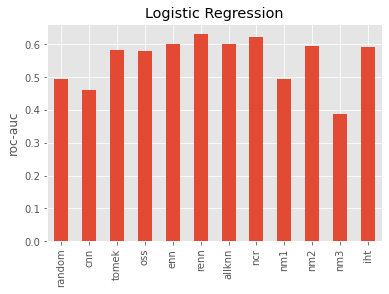

In [63]:
pd.Series(results_dict_LG1).plot.bar()
plt.title('Logistic Regression')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [64]:
conf_matrix_LG1

{'random': array([[39, 29],
        [ 8,  5]], dtype=int64),
 'cnn': array([[66,  2],
        [13,  0]], dtype=int64),
 'tomek': array([[68,  0],
        [13,  0]], dtype=int64),
 'oss': array([[68,  0],
        [13,  0]], dtype=int64),
 'enn': array([[68,  0],
        [13,  0]], dtype=int64),
 'renn': array([[62,  6],
        [12,  1]], dtype=int64),
 'allknn': array([[68,  0],
        [13,  0]], dtype=int64),
 'ncr': array([[68,  0],
        [13,  0]], dtype=int64),
 'nm1': array([[39, 29],
        [ 8,  5]], dtype=int64),
 'nm2': array([[45, 23],
        [ 7,  6]], dtype=int64),
 'nm3': array([[30, 38],
        [ 7,  6]], dtype=int64),
 'iht': array([[24, 44],
        [ 2, 11]], dtype=int64)}

c) False Negative Rate

In [65]:
FNR_dict_LG1

{'random': 0.6153846153846154,
 'cnn': 1.0,
 'tomek': 1.0,
 'oss': 1.0,
 'enn': 1.0,
 'renn': 0.9230769230769231,
 'allknn': 1.0,
 'ncr': 1.0,
 'nm1': 0.6153846153846154,
 'nm2': 0.5384615384615384,
 'nm3': 0.5384615384615384,
 'iht': 0.15384615384615385}

When we apply undersampling techniques we do not have the problem of overfitting. However for this model the performance is not good nor the FNR values is not good and neither are the FNR values except for the iht technique.

## 4.2 k-Nearest Neighbors

In [66]:
def run_KNN_1(X_train, X_test, y_train, y_test):
    
    '''This function applies k-Nearest Neighbors model.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
    
   
    
    grid_search_clf_gk = KNeighborsClassifier(n_neighbors=13, p=1, metric='minkowski' ) #When p = 1, this is equivalent to using manhattan_distance
 

    #grid_search_clf_gk = GridSearchCV(clf_gk, param_grid, cv = 3, n_jobs = -1, scoring='roc_auc', ) Overfitting
    grid_search_clf_gk.fit(X_train, y_train)
    
  
    
    print('Train set')
    pred = grid_search_clf_gk.predict_proba(X_train)
    print('KNN: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_clf_gk.predict_proba(X_test)
    print('KNN: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
     
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 


In [67]:
results_dict_KNN = {}
shapes_dict_KNN  = {}
conf_matrix_KNN  = {}
FNR_dict_KNN = {}
FPR_dict_KNN  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_KNN_1(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_KNN [undersampler] = roc[0]
    conf_matrix_KNN [undersampler] = roc[1]
    FPR_dict_KNN [undersampler] = roc[2]
    FNR_dict_KNN [undersampler] = roc[3]
    shapes_dict_KNN [undersampler] = len(X_resampled)  
    print()
    
print()

random
Train set
KNN: 0.7176405325443789
Test set
KNN: 0.5882352941176471

cnn
Train set
KNN: 0.7164102564102565
Test set
KNN: 0.5333710407239819

tomek
Train set
KNN: 0.8424612459783563
Test set
KNN: 0.5944570135746606

oss
Train set
KNN: 0.8437869822485207
Test set
KNN: 0.5944570135746606

enn
Train set
KNN: 0.8980957767722474
Test set
KNN: 0.5407239819004525

renn
Train set
KNN: 0.9318862275449102
Test set
KNN: 0.6402714932126696

allknn
Train set
KNN: 0.9013647642679901
Test set
KNN: 0.5910633484162896

ncr
Train set
KNN: 0.8665384615384616
Test set
KNN: 0.5588235294117647

nm1
Train set
KNN: 0.772189349112426
Test set
KNN: 0.6792986425339367

nm2
Train set
KNN: 0.8923816568047336
Test set
KNN: 0.4751131221719458

nm3
Train set
KNN: 0.7193047337278107
Test set
KNN: 0.4111990950226245

iht
Train set
KNN: 0.9443417159763313
Test set
KNN: 0.629524886877828




### **Summary of results**

a) summary of all roc-auc scores dependeng of sampling method

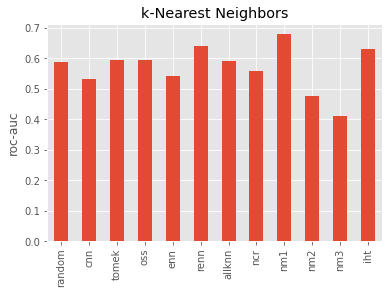

In [68]:
pd.Series(results_dict_KNN).plot.bar()
plt.title('k-Nearest Neighbors')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [69]:
conf_matrix_KNN

{'random': array([[38, 30],
        [ 7,  6]], dtype=int64),
 'cnn': array([[51, 17],
        [10,  3]], dtype=int64),
 'tomek': array([[68,  0],
        [11,  2]], dtype=int64),
 'oss': array([[68,  0],
        [11,  2]], dtype=int64),
 'enn': array([[67,  1],
        [11,  2]], dtype=int64),
 'renn': array([[62,  6],
        [ 9,  4]], dtype=int64),
 'allknn': array([[66,  2],
        [11,  2]], dtype=int64),
 'ncr': array([[67,  1],
        [11,  2]], dtype=int64),
 'nm1': array([[54, 14],
        [ 8,  5]], dtype=int64),
 'nm2': array([[11, 57],
        [ 3, 10]], dtype=int64),
 'nm3': array([[28, 40],
        [ 7,  6]], dtype=int64),
 'iht': array([[16, 52],
        [ 3, 10]], dtype=int64)}

c) False Negative Rate

In [70]:
FNR_dict_KNN

{'random': 0.5384615384615384,
 'cnn': 0.7692307692307693,
 'tomek': 0.8461538461538461,
 'oss': 0.8461538461538461,
 'enn': 0.8461538461538461,
 'renn': 0.6923076923076923,
 'allknn': 0.8461538461538461,
 'ncr': 0.8461538461538461,
 'nm1': 0.6153846153846154,
 'nm2': 0.23076923076923078,
 'nm3': 0.5384615384615384,
 'iht': 0.23076923076923078}

## 4.3 Decision Trees

In [71]:
def run_Decision_Tree(X_train, X_test, y_train, y_test):
    
    
    dtc = DecisionTreeClassifier()

    parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : np.arange(1, 5),
    'min_samples_leaf' :  np.arange(1, 5),
    'min_samples_split' :  np.arange(1, 5),
    'splitter' : ['best', 'random']
        
}
    
    grid_search_dt = GridSearchCV(dtc, parameters, cv = 3, n_jobs = -1, scoring='roc_auc') #ccv = 5-fold cross validation, n_jobs =# run in parallel
    grid_search_dt.fit(X_train, y_train)
    
  
    
    print('Train set')
    pred = grid_search_dt.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_dt.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_dt.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_dt.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
     
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 
    

In [72]:
results_dict_DT = {}
shapes_dict_DT  = {}
conf_matrix_DT  = {}
FNR_dict_DT = {}
FPR_dict_DT  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_Decision_Tree(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_DT [undersampler] = roc[0]
    conf_matrix_DT [undersampler] = roc[1]
    FPR_dict_DT [undersampler] = roc[2]
    FNR_dict_DT [undersampler] = roc[3]
    shapes_dict_DT [undersampler] = len(X_resampled)  
    print()
    
print()

random
Train set
Decision Tree: 0.7784763313609466
Test set
Decision Tree: 0.6153846153846153

cnn
Train set
Decision Tree: 0.7542307692307691
Test set
Decision Tree: 0.6176470588235294

tomek
Train set
Decision Tree: 0.6725650775080433
Test set
Decision Tree: 0.5463800904977376

oss
Train set
Decision Tree: 0.8131286982248521
Test set
Decision Tree: 0.6566742081447964

enn
Train set
Decision Tree: 0.6716628959276019
Test set
Decision Tree: 0.5271493212669683

renn
Train set
Decision Tree: 0.7377936434822663
Test set
Decision Tree: 0.5950226244343891

allknn
Train set
Decision Tree: 0.6802626137303557
Test set
Decision Tree: 0.5271493212669683

ncr
Train set
Decision Tree: 0.6976923076923077
Test set
Decision Tree: 0.5373303167420814

nm1
Train set
Decision Tree: 0.7971523668639054
Test set
Decision Tree: 0.4779411764705882

nm2
Train set
Decision Tree: 0.7217085798816568
Test set
Decision Tree: 0.4898190045248869

nm3
Train set
Decision Tree: 0.7000739644970413
Test set
Decision Tree:

### **Summary of results**

a) Summary of all roc-auc scores dependeng of sampling method

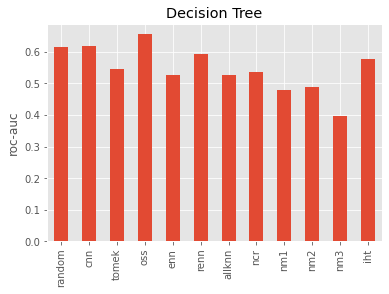

In [73]:
pd.Series(results_dict_DT).plot.bar()
plt.title('Decision Tree')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [21]:
conf_matrix_DT

{'random': array([[41, 27],
        [ 6,  7]], dtype=int64),
 'cnn': array([[53, 15],
        [ 8,  5]], dtype=int64),
 'tomek': array([[66,  2],
        [13,  0]], dtype=int64),
 'oss': array([[68,  0],
        [13,  0]], dtype=int64),
 'enn': array([[66,  2],
        [13,  0]], dtype=int64),
 'renn': array([[46, 22],
        [ 7,  6]], dtype=int64),
 'allknn': array([[68,  0],
        [13,  0]], dtype=int64),
 'ncr': array([[66,  2],
        [13,  0]], dtype=int64),
 'nm1': array([[48, 20],
        [ 8,  5]], dtype=int64),
 'nm2': array([[12, 56],
        [ 4,  9]], dtype=int64),
 'nm3': array([[33, 35],
        [ 7,  6]], dtype=int64),
 'iht': array([[20, 48],
        [ 4,  9]], dtype=int64)}

c) False Negative Rate

In [22]:
FNR_dict_DT

{'random': 0.46153846153846156,
 'cnn': 0.6153846153846154,
 'tomek': 1.0,
 'oss': 1.0,
 'enn': 1.0,
 'renn': 0.5384615384615384,
 'allknn': 1.0,
 'ncr': 1.0,
 'nm1': 0.6153846153846154,
 'nm2': 0.3076923076923077,
 'nm3': 0.5384615384615384,
 'iht': 0.3076923076923077}

In [23]:
def run_Decision_Tree(X_train, X_test, y_train, y_test):
    
    '''This function Decision Tree model.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
    
    
    grid_search_dt = DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
    grid_search_dt.fit(X_train, y_train)
    

    
    print('Train set')
    pred = grid_search_dt.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_dt.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_dt.predict(X_test))
     #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_dt.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 

In [24]:
results_dict_DT = {}
shapes_dict_DT  = {}
conf_matrix_DT  = {}
FNR_dict_DT = {}
FPR_dict_DT  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_Decision_Tree(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_DT [undersampler] = roc[0]
    conf_matrix_DT [undersampler] = roc[1]
    FPR_dict_DT [undersampler] = roc[2]
    FNR_dict_DT [undersampler] = roc[3]
    shapes_dict_DT [undersampler] = len(X_resampled)  
    print()
    
print()

random
Train set
Decision Tree: 0.7396449704142012
Test set
Decision Tree: 0.5361990950226244

cnn
Train set
Decision Tree: 0.6091025641025641
Test set
Decision Tree: 0.625

tomek
Train set
Decision Tree: 0.8141269377010822
Test set
Decision Tree: 0.548076923076923

oss
Train set
Decision Tree: 0.8132396449704142
Test set
Decision Tree: 0.548076923076923

enn
Train set
Decision Tree: 0.7980297888386124
Test set
Decision Tree: 0.5571266968325792

renn
Train set
Decision Tree: 0.8743090741593735
Test set
Decision Tree: 0.627262443438914

allknn
Train set
Decision Tree: 0.8077956989247312
Test set
Decision Tree: 0.5571266968325792

ncr
Train set
Decision Tree: 0.8311057692307693
Test set
Decision Tree: 0.6753393665158371

nm1
Train set
Decision Tree: 0.8115754437869822
Test set
Decision Tree: 0.5797511312217194

nm2
Train set
Decision Tree: 0.9142011834319527
Test set
Decision Tree: 0.5124434389140271

nm3
Train set
Decision Tree: 0.803439349112426
Test set
Decision Tree: 0.58088235294117

In [25]:
FNR_dict_DT

{'random': 0.07692307692307693,
 'cnn': 1.0,
 'tomek': 1.0,
 'oss': 1.0,
 'enn': 1.0,
 'renn': 0.7692307692307693,
 'allknn': 1.0,
 'ncr': 0.7692307692307693,
 'nm1': 0.38461538461538464,
 'nm2': 0.3076923076923077,
 'nm3': 0.6153846153846154,
 'iht': 0.3076923076923077}

 ## 4.4 Support Vector Machine

In [26]:
def run_SVC(X_train, X_test, y_train, y_test):
    
    svc = SVC(probability = True, random_state = 42)
    param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                      'gamma': ['scale', 'auto'],
                                      'C': [.1, 1, 2]},
                                     {'kernel': ['linear'], 
                                      'C': [.1, 1, 10]}]

    clf_svc = GridSearchCV(svc, param_grid = param_grid, scoring ='roc_auc', cv = 5, verbose = False, n_jobs = -1)
    best_clf_svc = clf_svc.fit(X_train, y_train)
    print('Train set')
    pred = best_clf_svc.predict_proba(X_train)
    print('SVC: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_svc.predict_proba(X_test)
    print('SVC: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_svc.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_svc.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 
    


In [27]:
results_dict_SVC = {}
shapes_dict_SVC  = {}
conf_matrix_SVC  = {}
FNR_dict_SVC = {}
FPR_dict_SVC  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_SVC(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_SVC [undersampler] = roc[0]
    conf_matrix_SVC [undersampler] = roc[1]
    FPR_dict_SVC [undersampler] = roc[2]
    FNR_dict_SVC [undersampler] = roc[3]
    shapes_dict_SVC [undersampler] = len(X_resampled)  
    print()
    
print()

random
Train set
SVC: 0.8923816568047337
Test set
SVC: 0.5542986425339367

cnn
Train set
SVC: 0.18461538461538463
Test set
SVC: 0.503393665158371

tomek
Train set
SVC: 0.9800380228136882
Test set
SVC: 0.583710407239819

oss
Train set
SVC: 0.9683431952662721
Test set
SVC: 0.5723981900452488

enn
Train set
SVC: 0.9863310708898945
Test set
SVC: 0.576923076923077

renn
Train set
SVC: 0.933901427913404
Test set
SVC: 0.6018099547511313

allknn
Train set
SVC: 0.9826302729528535
Test set
SVC: 0.5690045248868778

ncr
Train set
SVC: 0.9859615384615384
Test set
SVC: 0.5497737556561086

nm1
Train set
SVC: 0.2050665680473373
Test set
SVC: 0.47058823529411764

nm2
Train set
SVC: 0.9445266272189349
Test set
SVC: 0.5486425339366516

nm3
Train set
SVC: 0.8509615384615384
Test set
SVC: 0.3608597285067873

iht
Train set
SVC: 1.0
Test set
SVC: 0.5294117647058824




### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

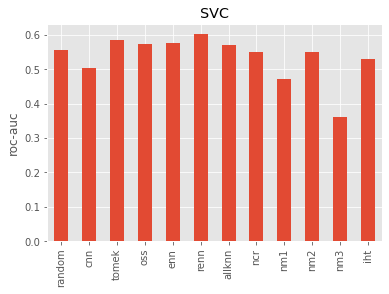

In [28]:
pd.Series(results_dict_SVC).plot.bar()
plt.title('SVC')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [29]:
conf_matrix_SVC

{'random': array([[41, 27],
        [ 6,  7]], dtype=int64),
 'cnn': array([[66,  2],
        [13,  0]], dtype=int64),
 'tomek': array([[68,  0],
        [13,  0]], dtype=int64),
 'oss': array([[68,  0],
        [13,  0]], dtype=int64),
 'enn': array([[64,  4],
        [ 9,  4]], dtype=int64),
 'renn': array([[59,  9],
        [10,  3]], dtype=int64),
 'allknn': array([[61,  7],
        [ 9,  4]], dtype=int64),
 'ncr': array([[64,  4],
        [ 9,  4]], dtype=int64),
 'nm1': array([[61,  7],
        [11,  2]], dtype=int64),
 'nm2': array([[10, 58],
        [ 2, 11]], dtype=int64),
 'nm3': array([[31, 37],
        [ 7,  6]], dtype=int64),
 'iht': array([[31, 37],
        [ 5,  8]], dtype=int64)}

c) False Negative Rate

In [30]:
FNR_dict_SVC

{'random': 0.46153846153846156,
 'cnn': 1.0,
 'tomek': 1.0,
 'oss': 1.0,
 'enn': 0.6923076923076923,
 'renn': 0.7692307692307693,
 'allknn': 0.6923076923076923,
 'ncr': 0.6923076923076923,
 'nm1': 0.8461538461538461,
 'nm2': 0.15384615384615385,
 'nm3': 0.5384615384615384,
 'iht': 0.38461538461538464}

## 4.5 RandomForest

In [75]:
def run_RF(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(random_state = 42)
    param_grid = {'n_estimators': [50],
                  'criterion': ['entropy', 'gini'],
                  'bootstrap': [True],
                  'max_depth': [6],
                  'max_features': ['auto','sqrt'],
                  'min_samples_leaf': [2, 3, 5],
                  'min_samples_split': [2, 3, 5]}
    
    clf_rf = GridSearchCV(rf, param_grid = param_grid, scoring = 'roc_auc', cv = 5, verbose = False, n_jobs = -1)
    best_clf_rf = clf_rf.fit(X_train, y_train)
    
    print("Best: %f using %s" % (best_clf_rf.best_score_, best_clf_rf.best_params_))
    
    
    print('Train set')
    pred = best_clf_rf.predict_proba(X_train)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_rf.predict_proba(X_test)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_rf.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_rf.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR

In [76]:
results_dict_RF = {}
shapes_dict_RF  = {}
conf_matrix_RF  = {}
FNR_dict_RF = {}
FPR_dict_RF  = {}


for undersampler in undersampler_dict.keys():
    print(undersampler)
    
    #resample
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_RF(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_RF [undersampler] = roc[0]
    conf_matrix_RF [undersampler] = roc[1]
    FPR_dict_RF [undersampler] = roc[2]
    FNR_dict_RF [undersampler] = roc[3]
    shapes_dict_RF [undersampler] = len(X_resampled)  
    print()
    
print()

random
Best: 0.442909 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Train set
Random Forest roc-auc: 0.9914940828402367
Test set
Random Forest roc-auc: 0.6753393665158371

cnn
Best: 0.525879 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Train set
Random Forest roc-auc: 0.994102564102564
Test set
Random Forest roc-auc: 0.5916289592760182

tomek
Best: 0.411921 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Train set
Random Forest roc-auc: 0.9850833577069319
Test set
Random Forest roc-auc: 0.6719457013574661

oss
Best: 0.441853 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_est

### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

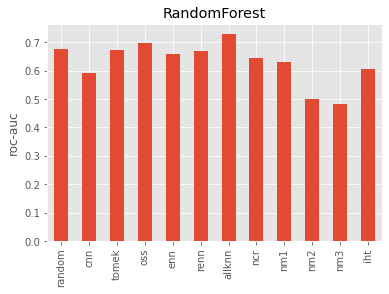

In [77]:
pd.Series(results_dict_RF).plot.bar()
plt.title('RandomForest')
plt.ylabel('roc-auc')

plt.show();

para quitar overfitting de RFtry reducing the depth or the number of trees

b) Confusion Matrix

In [78]:
conf_matrix_RF

{'random': array([[46, 22],
        [ 4,  9]], dtype=int64),
 'cnn': array([[53, 15],
        [ 9,  4]], dtype=int64),
 'tomek': array([[67,  1],
        [12,  1]], dtype=int64),
 'oss': array([[67,  1],
        [12,  1]], dtype=int64),
 'enn': array([[64,  4],
        [13,  0]], dtype=int64),
 'renn': array([[60,  8],
        [ 8,  5]], dtype=int64),
 'allknn': array([[66,  2],
        [13,  0]], dtype=int64),
 'ncr': array([[66,  2],
        [12,  1]], dtype=int64),
 'nm1': array([[26, 42],
        [ 2, 11]], dtype=int64),
 'nm2': array([[12, 56],
        [ 4,  9]], dtype=int64),
 'nm3': array([[28, 40],
        [ 6,  7]], dtype=int64),
 'iht': array([[20, 48],
        [ 3, 10]], dtype=int64)}

c) False Negative Rate

In [79]:
FNR_dict_RF

{'random': 0.3076923076923077,
 'cnn': 0.6923076923076923,
 'tomek': 0.9230769230769231,
 'oss': 0.9230769230769231,
 'enn': 1.0,
 'renn': 0.6153846153846154,
 'allknn': 1.0,
 'ncr': 0.9230769230769231,
 'nm1': 0.15384615384615385,
 'nm2': 0.3076923076923077,
 'nm3': 0.46153846153846156,
 'iht': 0.23076923076923078}

# 5. Summary and conclusions

With oversampling techniques we obtain several models with low FNR values, however the performances are worse.

In [36]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['No Rcidiva','Recidiva']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    plt.title("Confusion matrix")
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='white')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)
    FPR = fp / (tn + fp)
    FNR = fn / (tp + fn)

    
    print('roc_auc_test: {}'.format(roc_auc_score(y_test, pred[:,1])))
    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))
    print('False Positive Rate={0:0.3f}'.format(FPR))
    print('False Negative Rate={0:0.3f}'.format(FNR))

### Logistic_Regression. iht: Instance Hardness Threshold

In [44]:
iht = InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto', # resamples the majority class
        random_state=0,
        n_jobs=4,
        cv = 3)#cross validation fold
        
X_iht, y_iht = iht.fit_resample(X_train, y_train)

In [45]:
LG = LogisticRegression(random_state=42, solver= 'liblinear', C=1, penalty='l2' )
LG.fit(X_iht, y_iht)
pred = LG.predict_proba(X_test)

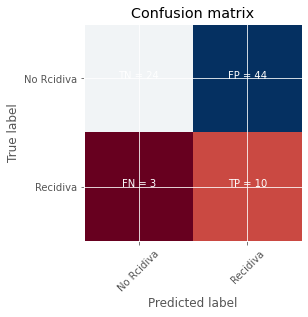

roc_auc_test: 0.6346153846153846
Recall=0.769 
Precision=0.185
F1=0.299
False Positive Rate=0.647
False Negative Rate=0.231


In [46]:
plot_cm(LG, LG.predict(X_test))

### KNN. iht: Instance Hardness Threshold

Although with other techniques such as random we have better scores, we choose as the best model the one with the lowest FNR value.

In [47]:
KNN= KNeighborsClassifier(n_neighbors=13, p=1, metric='minkowski' ) 
 
KNN.fit(X_iht, y_iht) #calculate before
pred = KNN.predict_proba(X_test)  

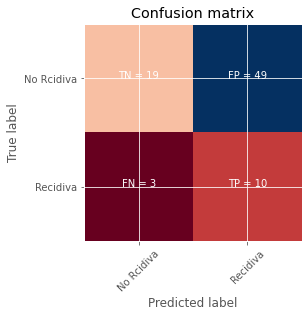

roc_auc_test: 0.6108597285067874
Recall=0.769 
Precision=0.169
F1=0.278
False Positive Rate=0.721
False Negative Rate=0.231


In [48]:
plot_cm(KNN, KNN.predict(X_test))

### Decision Tree: random

In [53]:
rus = RandomUnderSampler(
        sampling_strategy='auto',
        random_state=42,
        replacement=True)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [54]:
DT= DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
DT.fit(X_resampled, y_resampled)
pred= DT.predict_proba(X_test)

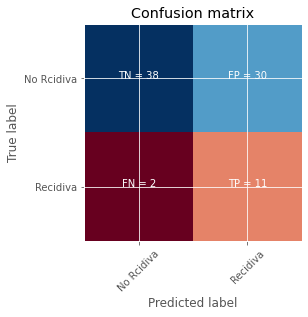

roc_auc_test: 0.7375565610859729
Recall=0.846 
Precision=0.268
F1=0.407
False Positive Rate=0.441
False Negative Rate=0.154


In [55]:
plot_cm(DT, DT.predict(X_test))

Changing the parameter of ramdon sampling: replacement, i realize is a good performance

In [58]:
rus = RandomUnderSampler(
        sampling_strategy='auto',
        random_state=42,
        replacement=False)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

DT= DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
DT.fit(X_resampled, y_resampled)
pred= DT.predict_proba(X_test)

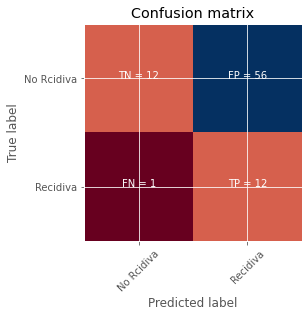

roc_auc_test: 0.5361990950226244
Recall=0.923 
Precision=0.176
F1=0.296
False Positive Rate=0.824
False Negative Rate=0.077


In [59]:
plot_cm(DT, DT.predict(X_test))

### Random Forest: NearMiss

In [74]:
nm1 = NearMiss(
        sampling_strategy='auto', # resamples the majority class
        version=1,
        n_neighbors=3, #3KNN
        n_jobs=-1)
        
X_nm1, y_nm1 = nm1.fit_resample(X_train, y_train)

In [84]:
rf = RandomForestClassifier(random_state = 42, bootstrap=True, criterion='entropy', max_depth=6, max_features='auto', min_samples_leaf=2, min_samples_split=5)

rf.fit(X_nm1, y_nm1)
pred=rf.predict_proba(X_test)

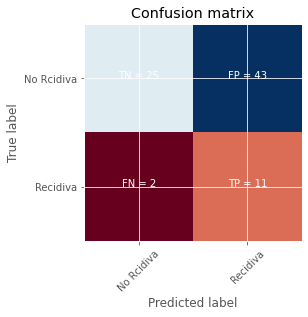

roc_auc_test: 0.6063348416289593
Recall=0.846 
Precision=0.204
F1=0.328
False Positive Rate=0.632
False Negative Rate=0.154


In [85]:
plot_cm(rf, rf.predict(X_test))